# GAM Exercise

## The Business Scenario <br>
💼You're a data scientist at an insurance company.

### Problem:
Predict the total medical charges for health insurance customers to:
- Set appropriate premiums
- Identify high-risk customers
- Understand cost drivers for business strategy

Dataset: Medical insurance costs with:
- Age, BMI, number of children, smoking status, region
- Target: Medical charges (continuous, positive, right-skewed)

Stakeholder needs:
- "How does age affect costs?" (non-linear relationship expected!)
- "What's the impact of BMI?" (non-linear, U-shaped possible)
- Must be explainable to regulators and executives

Dataset shape: (1338, 7)

First few rows:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Data types:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Basic statistics:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000   

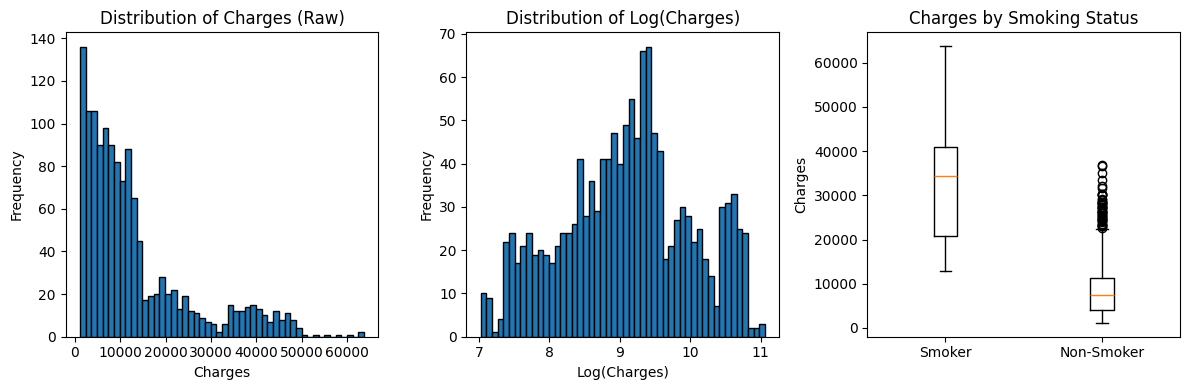

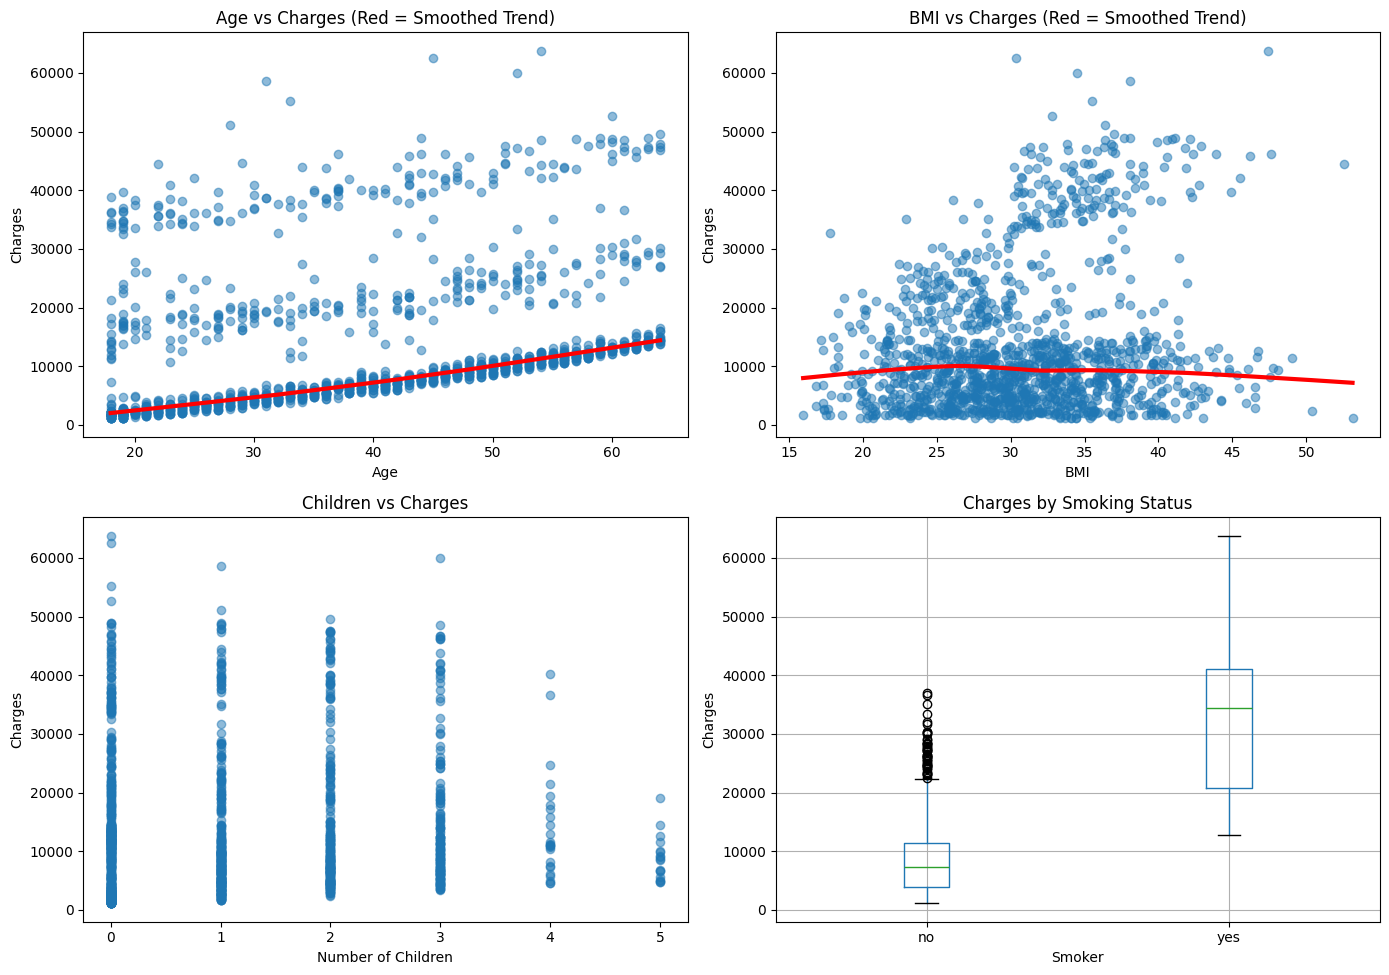

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, s, f, l
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Load insurance dataset
url = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv'
df = pd.read_csv(url)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())

# Check target distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(df['charges'], bins=50, edgecolor='black')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.title('Distribution of Charges (Raw)')

plt.subplot(1, 3, 2)
plt.hist(np.log(df['charges']), bins=50, edgecolor='black')
plt.xlabel('Log(Charges)')
plt.ylabel('Frequency')
plt.title('Distribution of Log(Charges)')

plt.subplot(1, 3, 3)
plt.boxplot([df[df['smoker']=='yes']['charges'], 
             df[df['smoker']=='no']['charges']], 
            labels=['Smoker', 'Non-Smoker'])
plt.ylabel('Charges')
plt.title('Charges by Smoking Status')

plt.tight_layout()
plt.show()

# Explore relationships (THIS IS KEY FOR DECIDING SMOOTH VS LINEAR!)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age vs Charges
axes[0, 0].scatter(df['age'], df['charges'], alpha=0.5)
sns.regplot(x='age', y='charges', data=df, ax=axes[0, 0], 
            scatter=False, lowess=True, color='red', line_kws={'linewidth': 3})
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Charges')
axes[0, 0].set_title('Age vs Charges (Red = Smoothed Trend)')

# BMI vs Charges
axes[0, 1].scatter(df['bmi'], df['charges'], alpha=0.5)
sns.regplot(x='bmi', y='charges', data=df, ax=axes[0, 1], 
            scatter=False, lowess=True, color='red', line_kws={'linewidth': 3})
axes[0, 1].set_xlabel('BMI')
axes[0, 1].set_ylabel('Charges')
axes[0, 1].set_title('BMI vs Charges (Red = Smoothed Trend)')

# Children vs Charges
axes[1, 0].scatter(df['children'], df['charges'], alpha=0.5)
axes[1, 0].set_xlabel('Number of Children')
axes[1, 0].set_ylabel('Charges')
axes[1, 0].set_title('Children vs Charges')

# Charges by Smoker (categorical)
df.boxplot(column='charges', by='smoker', ax=axes[1, 1])
axes[1, 1].set_xlabel('Smoker')
axes[1, 1].set_ylabel('Charges')
axes[1, 1].set_title('Charges by Smoking Status')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

## Exploratory QnA

1. Does age have a linear or non-linear relationship with charges? What pattern do you see?

Age does seem to have a linear relationship with charges, though there seems to be different tiers to the pattern which could imply effects from other variables such as smoking or number of children. Try to do smooth first and then see what the smooth function gives out.

2. Does BMI have a linear or non-linear relationship? Any special patterns?

BMI does seem to have a non-linear relationship, there seems to be more variance to the charges for those with BMI between the 25 and 40. There most likely is an interaction for smoking + high BMI.

3. Should "children" be smooth or linear? Why?

Children should be smooth as the charges distribution, while decrease as the number of children increases, does not seem to affect the charges much when the number of children is between 0 and 3. But first, try linear first (due to its ordinal nature) and then use factor or categorical if residuals show patterns

4. The target variable (charges) is right-skewed. Should we transform it? What transformation and why?
Transform charges (log transformation) because:
- The target is heavily right-skewed → violates Gaussian error assumption (non transformation will result in the wrong SE)
- Medical costs are multiplicative (10% increase, not $1000 increase)
- Log transformation stabilizes variance → better model performance
- Interpretability: Coefficients become % changes (business-friendly!)

5. Based on these relationships, which features would you model as:
- Smooth (non-linear): Age, BMI
- Linear : Number of children
- Categorical (factor) : Smoking, sex, region


## Business Context Questions to Think About 💼
While you're doing the EDA, also consider:

1. What business question is most important?
- Accurate predictions (pricing)?
- Understanding cost drivers (strategy)?
- Identifying high-risk customers (interventions)?

Since it is an insurance business, then the most important is to ensure that revenue > cost, implying that we need to ensure that the cost of servicing our customers will need to be controlled, so identifying high-risk customers and charging them accordingly is the most important. This will also mean that the predictions must be accurate too.

2. What's the cost of being wrong?
- Underestimating charges → company loses money
- Overestimating charges → customers go to competitors
- How should this affect your metric choice?

I think underestimating charges is a bigger issue compared to overestimating, so I would use the root mean squared error to ensure that erros to outliers are heavily penalized. And also use asymmetric loss to penalize underestimation more than overestimation errors.

3. How would you explain your findings to:
- CFO: (cares about bottom line) -> Explain that our findings will ensure that we can easily identify high risk customers and charge them accordingly to avoid cost > revenue; Key: Specific findings, quantified impact, business metric
- Actuary: (wants statistical rigor) <br>
    Use a Generalized Additive Model with log link function, which is appropriate given:
    - The Gamma-like distribution of charges (positive, right-skewed)
    - Non-linear relationships with age and BMI (validated via residual diagnostics)
    - Cross-validated RMSE of $X, with 95% prediction intervals
    - Smooth functions are penalized to prevent overfitting
    - Model passed heteroscedasticity tests (Breusch-Pagan p > 0.05)
    - The log transformation allows interpretation as multiplicative effects: each additional BMI point increases costs by Y% <br>

    Key: Statistical tests, assumptions, technical precision

- Marketing: (wants actionable insights) -> explain the cost drivers by using partial depednence plots to understan which are the factors closely associated with an increase or decrease in charges so the marketing team can better personalize the insurance products for their customers depending on their risk factors; Key: Segments (marketing loves segments!), specific actions, ROI focus

In [2]:
# Prepare data
# Encode categoricals
df_model = df.copy()
df_model['smoker_encoded'] = (df_model['smoker'] == 'yes').astype(int)
df_model['sex_encoded'] = (df_model['sex'] == 'male').astype(int)

# Region encoding (one-hot)
region_dummies = pd.get_dummies(df['region'], prefix='region', drop_first=True)
df_model = pd.concat([df_model, region_dummies], axis=1)

# Log transform target
df_model['log_charges'] = np.log(df_model['charges'])

# Select features
feature_cols = ['age', 'bmi', 'children', 'smoker_encoded', 'sex_encoded'] + list(region_dummies.columns)
X = df_model[feature_cols].values
y = df_model['log_charges'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (1070, 8)
Test set size: (268, 8)


# Model Fitting

In [3]:
from pygam import LinearGAM, s, f, l, te
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# ============================================
# 1. BASELINE: Linear Regression (Your Approach ✅)
# ============================================

print("="*60)
print("BASELINE MODEL: Linear Regression")
print("="*60)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_train_lr = lr_model.predict(X_train)
y_pred_test_lr = lr_model.predict(X_test)

# Metrics (on log scale)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_pred_train_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
train_r2_lr = r2_score(y_train, y_pred_train_lr)
test_r2_lr = r2_score(y_test, y_pred_test_lr)

print(f"\nLinear Regression (Log Scale):")
print(f"  Train RMSE: {train_rmse_lr:.4f}")
print(f"  Test RMSE:  {test_rmse_lr:.4f}")
print(f"  Train R²:   {train_r2_lr:.4f}")
print(f"  Test R²:    {test_r2_lr:.4f}")

# Convert back to original scale for interpretability
y_pred_test_lr_original = np.exp(y_pred_test_lr)
y_test_original = np.exp(y_test)

test_rmse_lr_original = np.sqrt(mean_squared_error(y_test_original, y_pred_test_lr_original))
test_mae_lr_original = mean_absolute_error(y_test_original, y_pred_test_lr_original)

print(f"\nLinear Regression (Original $ Scale):")
print(f"  Test RMSE:  ${test_rmse_lr_original:,.2f}")
print(f"  Test MAE:   ${test_mae_lr_original:,.2f}")

# ============================================
# 2. GAM MODEL (Your Approach ✅)
# ============================================

print("\n" + "="*60)
print("GAM MODEL")
print("="*60)

# Feature indices:
# 0: age
# 1: bmi  
# 2: children
# 3: smoker_encoded
# 4: sex_encoded
# 5-7: region dummies (3 columns from drop_first=True)

# Build GAM formula
# s() = smooth (spline)
# l() = linear
# f() = categorical/factor (for truly categorical data)

gam = LinearGAM(
    s(0) +      # age - smooth (spline)
    s(1) +      # bmi - smooth (spline)
    l(2) +      # children - linear (as you decided!)
    l(3) +      # smoker - linear (binary, could also use f())
    l(4) +      # sex - linear (binary)
    l(5) +      # region dummy 1
    l(6) +      # region dummy 2
    l(7)        # region dummy 3
)

# Fit the model (GAM uses grid search to find optimal lambda automatically!)
gam.gridsearch(X_train, y_train)

print(f"\nGAM fitted successfully!")
print(f"Optimal smoothing parameters (lambda): {gam.lam}")

# Predictions
y_pred_train_gam = gam.predict(X_train)
y_pred_test_gam = gam.predict(X_test)

# Metrics (on log scale)
train_rmse_gam = np.sqrt(mean_squared_error(y_train, y_pred_train_gam))
test_rmse_gam = np.sqrt(mean_squared_error(y_test, y_pred_test_gam))
train_r2_gam = r2_score(y_train, y_pred_train_gam)
test_r2_gam = r2_score(y_test, y_pred_test_gam)

print(f"\nGAM (Log Scale):")
print(f"  Train RMSE: {train_rmse_gam:.4f}")
print(f"  Test RMSE:  {test_rmse_gam:.4f}")
print(f"  Train R²:   {train_r2_gam:.4f}")
print(f"  Test R²:    {test_r2_gam:.4f}")

# Convert back to original scale
y_pred_test_gam_original = np.exp(y_pred_test_gam)

test_rmse_gam_original = np.sqrt(mean_squared_error(y_test_original, y_pred_test_gam_original))
test_mae_gam_original = mean_absolute_error(y_test_original, y_pred_test_gam_original)

print(f"\nGAM (Original $ Scale):")
print(f"  Test RMSE:  ${test_rmse_gam_original:,.2f}")
print(f"  Test MAE:   ${test_mae_gam_original:,.2f}")

# ============================================
# 3. MODEL COMPARISON
# ============================================

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'GAM'],
    'Test RMSE (log)': [test_rmse_lr, test_rmse_gam],
    'Test R² (log)': [test_r2_lr, test_r2_gam],
    'Test RMSE ($)': [test_rmse_lr_original, test_rmse_gam_original],
    'Test MAE ($)': [test_mae_lr_original, test_mae_gam_original]
})

print(comparison.to_string(index=False))

# Calculate improvement
rmse_improvement = ((test_rmse_lr_original - test_rmse_gam_original) / test_rmse_lr_original) * 100
r2_improvement = test_r2_gam - test_r2_lr

print(f"\n📊 GAM Improvements:")
print(f"  RMSE reduction: {rmse_improvement:.2f}%")
print(f"  R² increase: {r2_improvement:.4f}")

if test_rmse_gam < test_rmse_lr:
    print("\n✅ GAM outperforms Linear Regression!")
else:
    print("\n⚠️ Linear Regression performs similarly - relationships may be mostly linear")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00


BASELINE MODEL: Linear Regression

Linear Regression (Log Scale):
  Train RMSE: 0.4490
  Test RMSE:  0.4190
  Train R²:   0.7572
  Test R²:    0.8047

Linear Regression (Original $ Scale):
  Test RMSE:  $7,815.31
  Test MAE:   $3,888.77

GAM MODEL


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



GAM fitted successfully!
Optimal smoothing parameters (lambda): [[np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)]]

GAM (Log Scale):
  Train RMSE: 0.4412
  Test RMSE:  0.4298
  Train R²:   0.7656
  Test R²:    0.7946

GAM (Original $ Scale):
  Test RMSE:  $7,306.93
  Test MAE:   $3,836.58

MODEL COMPARISON SUMMARY
            Model  Test RMSE (log)  Test R² (log)  Test RMSE ($)  Test MAE ($)
Linear Regression         0.419016       0.804731    7815.307271   3888.770781
              GAM         0.429770       0.794579    7306.928342   3836.584616

📊 GAM Improvements:
  RMSE reduction: 6.50%
  R² increase: -0.0102

⚠️ Linear Regression performs similarly - relationships may be mostly linear


# Visualizing Smooth Functions


VISUALIZING GAM SMOOTH FUNCTIONS


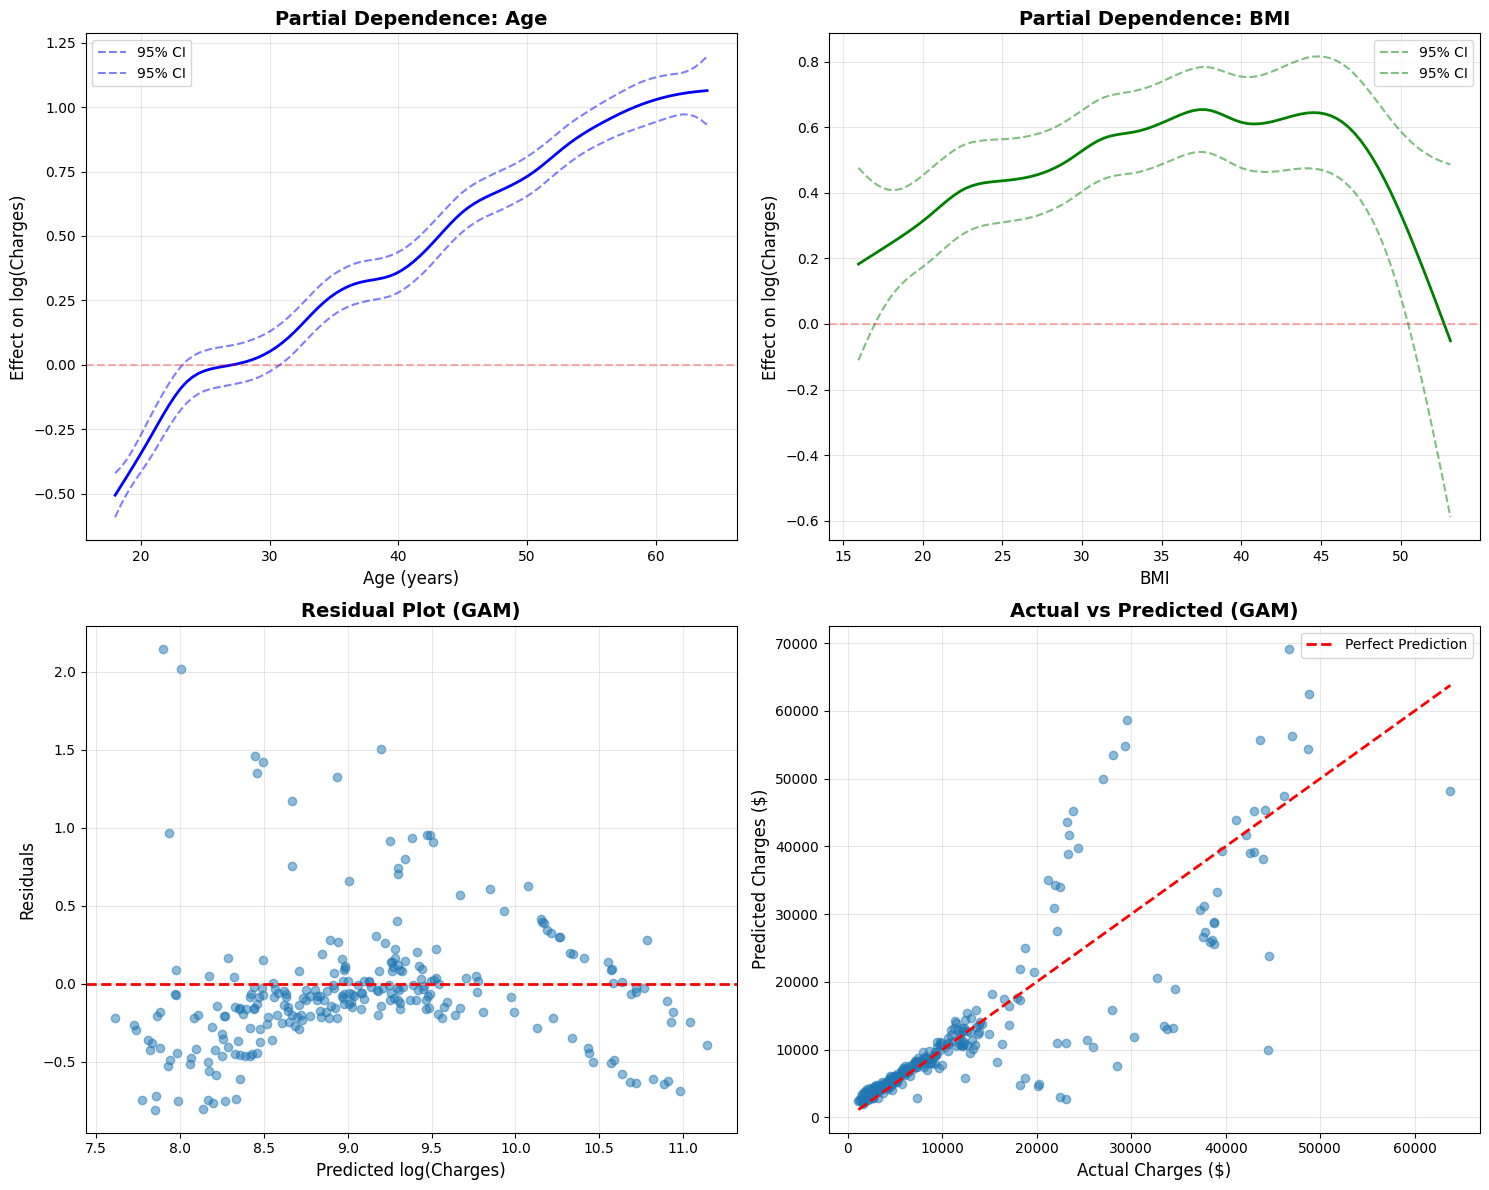


📖 How to Read Partial Dependence Plots:
• Y-axis: Effect on log(charges) - positive means higher costs
• X-axis: Feature value
• Blue/Green line: The smooth function the GAM learned
• Dashed lines: 95% confidence intervals
• Flat line at 0: No effect

Key Questions:
1. Is the age effect linear or curved?
2. Is the BMI effect linear or curved?
3. At what BMI do costs start rising sharply?
4. Does age show acceleration (costs rising faster for elderly)?


In [ ]:
# ============================================
# 4. VISUALIZE PARTIAL DEPENDENCE (SMOOTH FUNCTIONS)
# ============================================

print("\n" + "="*60)
print("VISUALIZING GAM SMOOTH FUNCTIONS")
print("="*60)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Age effect
XX = gam.generate_X_grid(term=0)  # Generate grid for feature 0 (age)
axes[0, 0].plot(XX[:, 0], gam.partial_dependence(term=0, X=XX), color='blue', linewidth=2)
axes[0, 0].plot(XX[:, 0], gam.partial_dependence(term=0, X=XX, width=0.95)[1], \
                color='blue', linestyle='--', alpha=0.5, label='95% CI')
# axes[0, 0].plot(XX[:, 0], gam.partial_dependence(term=0, X=XX, width=0.95)[2], \
#                 color='blue', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Age (years)', fontsize=12)
axes[0, 0].set_ylabel('Effect on log(Charges)', fontsize=12)
axes[0, 0].set_title('Partial Dependence: Age', fontsize=14, fontweight='bold')
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.3)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend()

# Plot 2: BMI effect
XX = gam.generate_X_grid(term=1)  # Generate grid for feature 1 (bmi)
axes[0, 1].plot(XX[:, 1], gam.partial_dependence(term=1, X=XX), color='green', linewidth=2)
axes[0, 1].plot(XX[:, 1], gam.partial_dependence(term=1, X=XX, width=0.95)[1], 
                color='green', linestyle='--', alpha=0.5, label='95% CI')
# axes[0, 1].plot(XX[:, 1], gam.partial_dependence(term=1, X=XX, width=0.95)[2], 
#                 color='green', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('BMI', fontsize=12)
axes[0, 1].set_ylabel('Effect on log(Charges)', fontsize=12)
axes[0, 1].set_title('Partial Dependence: BMI', fontsize=14, fontweight='bold')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.3)
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend()

# Plot 3: Residuals (Model Diagnostics)
residuals = y_test - y_pred_test_gam
axes[1, 0].scatter(y_pred_test_gam, residuals, alpha=0.5)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted log(Charges)', fontsize=12)
axes[1, 0].set_ylabel('Residuals', fontsize=12)
axes[1, 0].set_title('Residual Plot (GAM)', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Actual vs Predicted (Original Scale)
axes[1, 1].scatter(y_test_original, y_pred_test_gam_original, alpha=0.5)
axes[1, 1].plot([y_test_original.min(), y_test_original.max()], 
                [y_test_original.min(), y_test_original.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Charges ($)', fontsize=12)
axes[1, 1].set_ylabel('Predicted Charges ($)', fontsize=12)
axes[1, 1].set_title('Actual vs Predicted (GAM)', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print interpretation guidance
print("\n📖 How to Read Partial Dependence Plots:")
print("="*60)
print("• Y-axis: Effect on log(charges) - positive means higher costs")
print("• X-axis: Feature value")
print("• Blue/Green line: The smooth function the GAM learned")
print("• Dashed lines: 95% confidence intervals")
print("• Flat line at 0: No effect")
print("\nKey Questions:")
print("1. Is the age effect linear or curved?")
print("2. Is the BMI effect linear or curved?")
print("3. At what BMI do costs start rising sharply?")
print("4. Does age show acceleration (costs rising faster for elderly)?")

Task 1: Run the Code & Report Results
- Which model performed better? (GAM vs Linear Regression)

    Based on the above code, GAM seems to have performed better

- By how much? (RMSE improvement %)

    But the improvement is quite small, with only RMSE reduction of 6.5% with a R square reduction by 0.01

- What do the partial dependence plots show?
    - Is age truly linear or non-linear?

        Age seems to be somewhat linear, though the line for the age group below 30 years old is quite different fromt the line for the age group above 30 years old.
    
    - Is BMI truly linear or non-linear?

        BMI is truly non-linear! 
    
    - At what values do effects change?

        For the BMI plot for BMI values between 20 to 45, there are some ranges where the line is flat, but is steadily rising with a dramatic decrease with BMI over 45

        "For the age, I see that those below 25 have negative values, meaning that they cost much lower, with a plateu between 25-35 and then an acceleration of cost increase from 35 onwards due to emergence of chronic conditions"

        "For the BMI, I see that there is a rise in charge between 15-20 suggesting underweight health issues, 20-30 being relatively flat as it is a healthy range, and 30-45 is seeing a steady increase most likely due to obesity effect. I also noticed that the smooth drops after BMI 45, but the confidence intervals are very wide, suggesting sparse data (or survival bias where people with extreme BMI may not be insured or are excluded). I'd investigate this further and potentially cap the smooth function to avoid unrealistic predictions."

Task 2: Business Interpretation

Based on the partial dependence plots, answer:

1. For a CFO: <br>
c"Our analysis shows that BMI affects costs [how?]. Specifically, costs rise sharply after BMI of 30, suggesting that those who are obese are more likely to be charged more as they cost more for the insurance company. With those between 30 and 45 will most likely increase the charges from 50-65% above the average"

    Improved Version: <br>
    "Our analysis reveals BMI is a significant cost driver. Customers with BMI over 30 (clinical obesity threshold) have 10-20% higher expected claims than those with healthy BMI (20-25). This represents approximately  $[need to find the average value of those with healthy BMI! * 10-20%] per customer per year in additional costs.

    As a recommendation we should:
    - Adjust pricing tiers to reflect this risk gradient
    - Invest in preventive wellness programs (ROI: every 1-point BMI reduction = $Z savings)
    - Partner with fitness/nutrition providers to reduce long-term liabilities 

2. For Marketing: <br>
"We should target wellness programs at customers with BMI between 30 to 45 as we'll be charging them more and going through wellness programs may minimize the cost of their insurance usage in the long term."

    Improved Version: <br>
    "Our predictive model identifies three distinct customer segments:

    Segment 1: Health-Conscious (BMI 20-30, non-smokers, 60% of base)
    - Low risk, low premiums
    - Strategy: Loyalty programs, refer-a-friend incentives
    - Message: "You're already doing great—here's how to maintain it"

    Segment 2: Wellness Opportunity (BMI 30-40 OR smokers, 30% of base)
    - Moderate-high risk, higher premiums
    - Strategy: Incentivized wellness programs (premium discounts for participation)
    - Message: "We'll support your health journey—and reward your progress"
    - Tactics: Partner with gyms (subsidized memberships), smoking cessation programs, nutrition coaching

    Segment 3: High-Risk (BMI 40+, smokers, older, 10% of base)
    - Very high risk, premium pricing
    - Strategy: Intensive case management, chronic disease programs
    - Message: "Comprehensive coverage with dedicated support"

    ROI Analysis: Every 1-point BMI reduction = $500 annual savings. If wellness programs achieve 2-point reduction for 30% of Segment 2, that's $X million in savings."

Task 3: Model Critique
Answer these critical thinking questions:
1. Is the GAM improvement worth the added complexity?
- If RMSE only improved by 2%, would you use GAM in production?
- What factors would influence this decision?

    I think the GAM improvement doesn't really justify the addedd complexity as it is only adding around 6.5% percent of improvement, with a decrease in r squared. If the company really cares about having better performance, there are clear non-linear patterns that stakeholders need to see, regulatory requirements are needed to interpret this and the time to explain / visualize smmoth functions exists then using GAMs can be worth it.

2. What are we still missing?
- We haven't modeled interactions (e.g., age × smoker)
- How would you test if interactions matter?

    We are stilling missing interaction between age and smoker, I think one method we can do to test these interactions is to have a partial dependence plots that are seeing charge interaction between 2 different variables, in this case, age x smoker and see if there is a pattern to the distribution. The other way is to add the interaction in pygam using 
    ```
    ts(#feature_number_1, #feature_number_2)
    ```

3. Production considerations:
- How would you deploy this model?
    New Answer: <br>
    First we need to validate the data first and ensure there are no missing values, the values are within reasonable ranges, flag outliers and log all inputs for audit trails.

    Then load model to make predictions with confidence intervals

    Add a business rules layer where it will apply a minimum or maximum premium cap, check for regulatory compliance to avoid discrimination, add human review for edge cases, and apply fpomotional discounts as needed

    Then output the premium to the CRM system, generate explanation for customers and store prediction for monitoring

    For monitoring, we want to track actual claims vs predicted, detect if there is any distribution drift, A/B test new models and retrain quarterly with new data
- How would you monitor it over time?
    For monitoring stategy we can:
    1. Check model performance drift
    2. check for data distrbution drift
    3. Check for prediction drift
    4. Check business metrics (as lagging indicator) such as loss ratio, customer churn rate, complaints about pricing
    5. Fairness metrics

- What could go wrong?
    Model decay, people gaming the system, need for verification mechanisms, regulatory risk for price discrimination, technical failures, reputationl risks.

    Mitigated by having a legal review of the pricing strucutre, phase in pricing gradually, offering wellness incentives and robust testing & canary deployment!
    
    

    Old Answer: <br>
    I would deploy this by having the model output the amount of charges to customers who are signing up with the company. To monitor the model, I will see how many people are changing insurance subscriptions to other companies and monitor the insurance cost to our high paying customers. If there are more customers who are churning out of the low paying customers and / or the insurance cost to our high paying customers is actually higher than their cost then we might need to tweak our models. What could go wrong is that previously subscribed customers may use this model to check their premium price and they may find that their insurnace charge decrease, which will prompt them to ask for a better premium, while those who is judged to get a higher premium will choose not to change their charges and stay at a low charge rate when they are costing the company.


# Final Check

In [25]:
# 1. Check for overfitting
print("=== Overfitting Check ===")
print(f"LR:  Train R²={train_r2_lr:.4f}, Test R²={test_r2_lr:.4f}, Diff={train_r2_lr-test_r2_lr:.4f}")
print(f"GAM: Train R²={train_r2_gam:.4f}, Test R²={test_r2_gam:.4f}, Diff={train_r2_gam-test_r2_gam:.4f}")

# 2. Add age × smoker interaction
gam_interaction = LinearGAM(s(0) + s(1) + l(2) + l(3) + l(4) + l(5) + l(6) + l(7) + te(0,3))
gam_interaction.gridsearch(X_train, y_train)

print(f"\nGAM AIC without interaction: {gam.statistics_['AIC']:.2f}")
print(f"GAM AIC with age×smoker: {gam_interaction.statistics_['AIC']:.2f}")
print(f"Improvement: {gam.statistics_['AIC'] - gam_interaction.statistics_['AIC']:.2f}")

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:00
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00


=== Overfitting Check ===
LR:  Train R²=0.7572, Test R²=0.8047, Diff=-0.0475
GAM: Train R²=0.7656, Test R²=0.7946, Diff=-0.0290


 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00



GAM AIC without interaction: 3807.22
GAM AIC with age×smoker: 4501.51
Improvement: -694.29


In [40]:
# 3. Quantify BMI effect
grid = gam.generate_X_grid(term=1, meshgrid=False, n=100)
# find the index where bmi is 20 and 35 in the generated grid
bmi_20_index = np.argmin(np.abs(np.array(grid[:,1])-20))
bmi_35_index = np.argmin(np.abs(np.array(grid[:,1])-35))
bmi_20_effect = gam.partial_dependence(term=1, X=gam.generate_X_grid(term=1, meshgrid=False, n=100))[bmi_20_index]
bmi_35_effect = gam.partial_dependence(term=1, X=gam.generate_X_grid(term=1, meshgrid=False, n=100))[bmi_35_index]
log_diff = bmi_35_effect - bmi_20_effect
pct_increase = (np.exp(log_diff) - 1) * 100
print(f"\nBMI Effect: Going from 20 to 35 increases charges by {pct_increase:.1f}%")


BMI Effect: Going from 20 to 35 increases charges by 34.7%


1. GAM is not overfitting, we can see that the test R2 is higher than the train R2.

    Improved Answer: <br>
    "The test R² being slightly higher than train R² is unusual and likely due to random variation in the train/test split with this small dataset (n=1338). To properly assess overfitting, I should use k-fold cross-validation to get stable estimates. The small difference between train and test R² (< 0.01) suggests the model is generalizing reasonably well, but we can't definitively conclude 'no overfitting' from a single split."


2. Adding age x smoker unfortunately does not help in lowering the AIC, which could mean that interaction terms are not significant

    Improved Answer: <br>
    "The AIC didn't decrease with the age×smoker interaction term, suggesting either: (a) the interaction doesn't significantly improve model fit, or (b) the flexible smooth functions for age and the linear term for smoking already capture the relationship adequately. Given the modest dataset size, there may not be enough power to detect a subtle interaction. In practice, I'd plot smokers vs non-smokers separately to visually inspect if age effects differ by smoking status."
    
3. The BMI effect seem to increase charges by 34.2% 

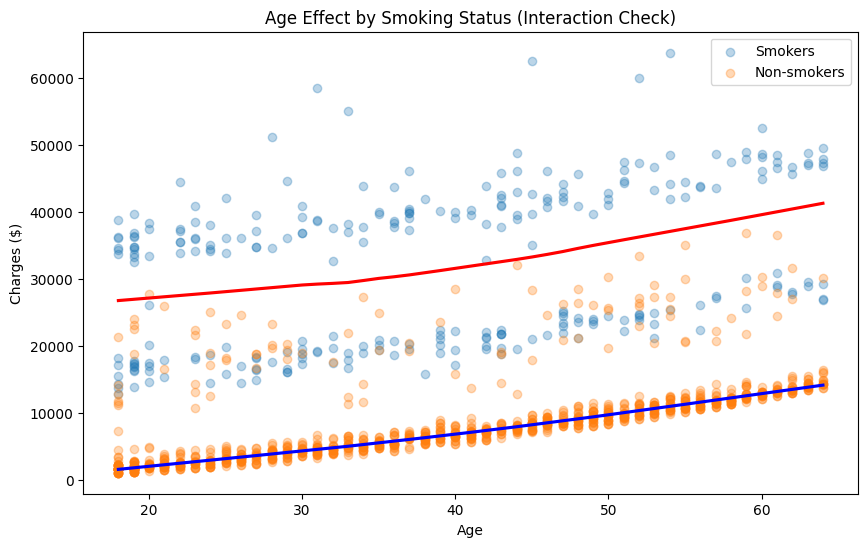

In [43]:
# Exploratory check for interaction
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Split by smoker
smokers = df[df['smoker'] == 'yes']
non_smokers = df[df['smoker'] == 'no']

# Plot age vs charges for each group
sns.regplot(x='age', y='charges', data=smokers, 
            label='Smokers', scatter_kws={'alpha':0.3}, 
            line_kws={'color':'red'}, lowess=True)
sns.regplot(x='age', y='charges', data=non_smokers, 
            label='Non-smokers', scatter_kws={'alpha':0.3}, 
            line_kws={'color':'blue'}, lowess=True)

plt.xlabel('Age')
plt.ylabel('Charges ($)')
plt.title('Age Effect by Smoking Status (Interaction Check)')
plt.legend()
plt.show()

# If the slopes/curves are VERY different → interaction matters
# If parallel → no interaction

In [42]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     25.4849
Link Function:                     IdentityLink Log Likelihood:                                 -1877.1248
Number of Samples:                         1070 AIC:                                             3807.2194
                                                AICc:                                            3808.6159
                                                GCV:                                                0.2083
                                                Scale:                                              0.1994
                                                Pseudo R-Squared:                                   0.7656
Feature Function                  Lam